In [16]:
import torch
from optimize_ARPDF import ARPDFModel, ARPDFOptimizer
from collections import Counter
import MDAnalysis as mda
import utils
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [18]:
X, Y, ARPDF_exp = utils.load_exp_data('data/CCl4', rmax=9.0)
u0 = mda.Universe('data/CCl4/CCl4.gro')
filter_fourier = lambda kX, kY, xp: (1 - xp.exp(-(kX**2 / 0.3 + kY**2 / 0.1)))**3 * xp.exp(-0.08 * (kX**2 + kY**2))
dir_name = "exp_scalecircle_5nm_cutoff_5"
device = 'cuda'
ARPDF_optimizer = ARPDFOptimizer(
    X, Y, ARPDF_exp, Counter(u0.atoms.types), filter_fourier=filter_fourier, cutoff=10.0, 
    lr=0.01, gamma=0.995, f_lb=-0.9, s=0.0, beta=0.0, epochs=500, device=device
)
ARPDF_optimizer.set_system(out_dir=f'tmp/{dir_name}')

In [ ]:
# print(json.dumps({k: str(type(v)) for k, v in ARPDF_optimizer.__dict__.items()}, indent=4))
# print(json.dumps({k: str(type(v)) for k, v in ARPDF_optimizer.model.__dict__.items()}, indent=4))

Optimizing Atoms:   1%|          | 6/500 [00:00<00:17, 28.74it/s]

Epoch 0: Loss=0.042564, CosSim=0.117880, LR=0.009950


Optimizing Atoms:  12%|█▏        | 58/500 [00:01<00:11, 37.27it/s]

Epoch 50: Loss=-0.023280, CosSim=0.135655, LR=0.007744


Optimizing Atoms:  21%|██        | 106/500 [00:02<00:10, 37.24it/s]

Epoch 100: Loss=-0.029163, CosSim=0.142710, LR=0.006027


Optimizing Atoms:  32%|███▏      | 158/500 [00:04<00:09, 37.63it/s]

Epoch 150: Loss=-0.033036, CosSim=0.154411, LR=0.004691


Optimizing Atoms:  41%|████      | 206/500 [00:05<00:07, 37.69it/s]

Epoch 200: Loss=-0.036313, CosSim=0.157997, LR=0.003651


Optimizing Atoms:  52%|█████▏    | 258/500 [00:06<00:06, 37.78it/s]

Epoch 250: Loss=-0.037553, CosSim=0.165619, LR=0.002842


Optimizing Atoms:  61%|██████    | 306/500 [00:08<00:05, 37.80it/s]

Epoch 300: Loss=-0.037403, CosSim=0.166253, LR=0.002212


Optimizing Atoms:  72%|███████▏  | 358/500 [00:09<00:03, 36.74it/s]

Epoch 350: Loss=-0.037311, CosSim=0.166386, LR=0.001721


Optimizing Atoms:  81%|████████  | 406/500 [00:10<00:02, 37.59it/s]

Epoch 400: Loss=-0.037322, CosSim=0.166379, LR=0.001340


Optimizing Atoms:  92%|█████████▏| 458/500 [00:12<00:01, 37.72it/s]

Epoch 450: Loss=-0.037329, CosSim=0.166336, LR=0.001043


Optimizing Atoms: 100%|██████████| 500/500 [00:13<00:00, 37.45it/s]


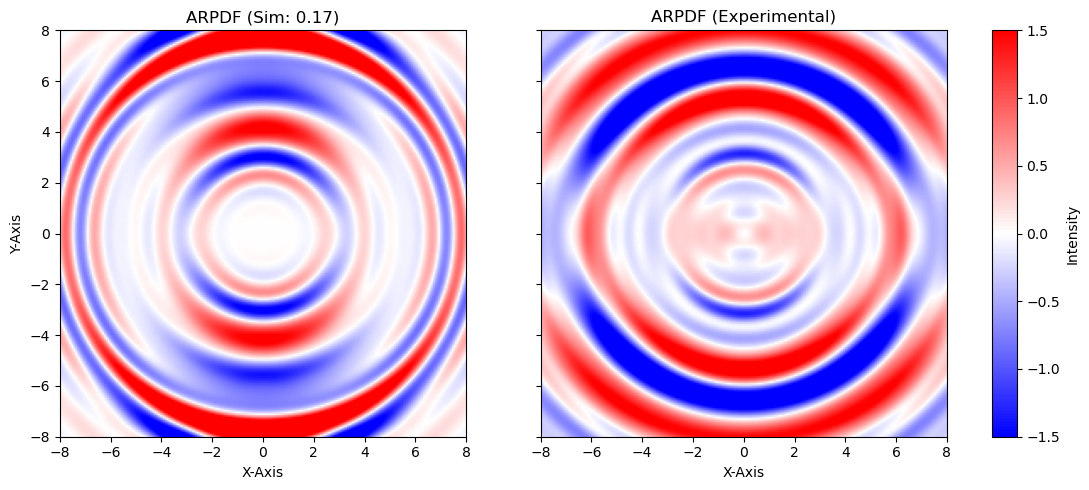

In [19]:
ARPDF_optimizer.optimize()

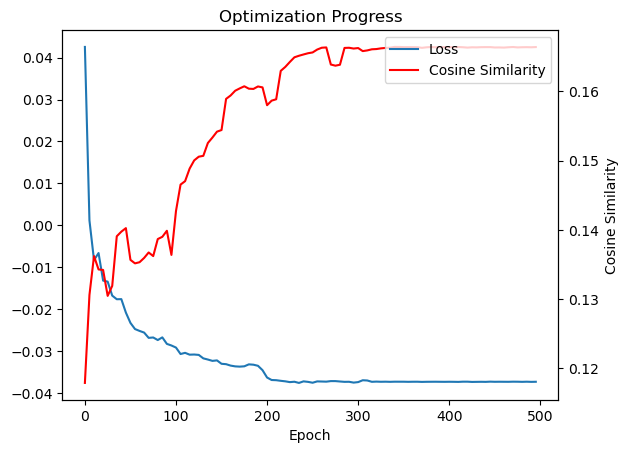

In [20]:
df = pd.read_csv(f"tmp/{dir_name}/log.txt")
epochs = df['epoch'].values
loss = df['loss'].values
cos_sim = df['cos_sim'].values
line1, = plt.plot(epochs, loss, label='Loss')
plt.xlabel('Epoch')
plt.twinx()
line2, = plt.plot(epochs, cos_sim, label='Cosine Similarity', color='red')
plt.ylabel('Cosine Similarity')
plt.legend([line1, line2], ['Loss', 'Cosine Similarity'], loc='upper right')
plt.title('Optimization Progress')
plt.show()

In [21]:
u1, u2, modified_atoms, polar_axis = utils.load_structure_data(f'tmp/{dir_name}')
polar_axis = np.array(polar_axis)
polar_axis /= np.linalg.norm(polar_axis)
# u2 = mda.Universe('tmp/cos_sim/CCl4_best_init.gro')
trajs = np.load(f"tmp/{dir_name}/traj.npy")[::5]

def rotation_matrix(v1, v2):
    u = v1 - v2
    if np.linalg.norm(u) < 1e-8:
        return np.eye(3)
    u /= np.linalg.norm(u)
    return np.eye(3) - 2 * np.outer(u, u)

R = rotation_matrix(polar_axis, np.array([0., 0., 1.]))
center_group = u2.atoms[modified_atoms]
_center = center_group[0].position[None, :]
around_group = u2.select_atoms("around 6.0 group center", center = center_group, periodic=True)
center_group.positions = utils.box_shift(center_group.positions - _center, u2.dimensions) @ R.T
around_group.positions = utils.box_shift(around_group.positions - _center, u2.dimensions) @ R.T
trajs = utils.box_shift(trajs - _center[None, :, :], u2.dimensions) @ R.T
full_trajs = np.zeros((trajs.shape[0], center_group.n_atoms + around_group.n_atoms, 3))
full_trajs[:, :center_group.n_atoms, :] = trajs
full_trajs[:, center_group.n_atoms:, :] = around_group.positions[None, :, :]
u_new = mda.Merge(center_group, around_group)
u_new.load_new(full_trajs[1:], format="memory", dt=1.0)
# print(around_group.positions[:5])
with mda.Writer(f"tmp/{dir_name}/traj.xyz", center_group.n_atoms + around_group.n_atoms) as W:
    for ts in u_new.trajectory:
        W.write(u_new.atoms)